In [1]:
pip install git+https://github.com/christopherjenness/DBCV.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/christopherjenness/DBCV.git (to revision master) to /tmp/pip-req-build-dxkkun1o
  Running command git clone -q https://github.com/christopherjenness/DBCV.git /tmp/pip-req-build-dxkkun1o
  Created wheel for DBCV: filename=DBCV-0.0.0-py3-none-any.whl size=4211 sha256=2b9ba73f592a651851d6957311f097a6f34cecf4598284dc2f19dbe6e1c0170e
  Stored in directory: /tmp/pip-ephem-wheel-cache-z5ypx7q6/wheels/60/0f/5b/eeba98b8dd0fdd3c1f41a9c6711ae84a166862fd1dfc250af3
Successfully built DBCV


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, PowerTransformer, RobustScaler
from sklearn.metrics import silhouette_samples, calinski_harabasz_score
from google.colab import files
import numpy as np
from sklearn.cluster import DBSCAN
from DBCV import DBCV
from yellowbrick.cluster import SilhouetteVisualizer,KElbowVisualizer
from scipy.spatial.distance import euclidean

In [3]:
uploaded = files.upload()
csv = next(iter(uploaded))

Saving life-expectancy.csv to life-expectancy.csv


> Escreva a justificativa para a escolha de dados, dando sua motivação e objetivos

#### Foi escolhida a base de dados life expectancy do Kaggle, esta possui a relação de 142 países do qual é avaliado em 04 features (expectativa de vida homem, expectativa de vida mulher, avaliação de felicidade (não categorico) e taxa de fertilidade (por mulher). Fora observado dentro do repositório Kaggle a melhor estrutura de dados do qual pudesse ser avaliado e implementado índices de validação para clusters baseados em classificação e com distribuição mais uniforme possível com índice de correlação alto. Esta base de dados enquadrou da melhor maneira. 

In [4]:
df_life_expec = pd.read_csv(csv, sep=",",index_col=0)
df_life_expec.head(6)

,Life Expectancy (years) - Men,Life Expectancy (years) - Women,Happiness Score,Fertility Rate (births per woman)
Country,,,,
Afghanistan,60.6,68.2,3.794,4.7
Albania,74.8,81.3,4.959,1.7
Algeria,73.3,78.9,5.605,2.9
Andorra,81.7,84.8,6.955,1.4
Angola,58.1,65.6,4.105,5.3
Antigua and Barbuda,74.4,78.9,6.102,2.2


> Mostre através de gráficos a faixa dinâmica das variáveis que serão usadas nas tarefas de clusterização. Analise os resultados mostrados. O que deve ser feito com os dados antes da etapa de clusterização?

In [5]:
# Função de plot de distribuição para algoritimos do Kmeans
def plot_cluster_points(df, kmeans):
    pca = PCA(2) 
    pca_data = pd.DataFrame(pca.fit_transform(df), columns=['PC1','PC2']) 
    pca_data['cluster'] = pd.Categorical(kmeans.labels_)
    sns.scatterplot(x="PC1", y="PC2", hue="cluster", data=pca_data)

# Função de plot de distribuição para algoritimos do dbScan
def plot_dbScan_points(df, dbscan):
    pca = PCA(2) 
    pca_data = pd.DataFrame(pca.fit_transform(df), columns=['PC1','PC2']) 
    pca_data['cors'] = pd.Categorical(dbscan.labels_)
    sns.scatterplot(x="PC1", y="PC2", hue="cors", data=pca_data)

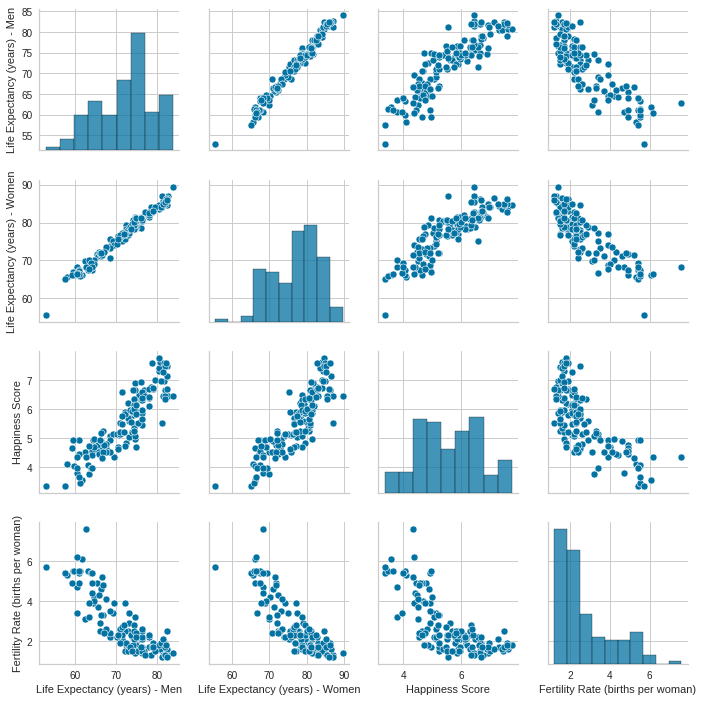

In [6]:
# Exibição da faixa dinâmica de dados
sns.pairplot(df_life_expec)

> Realize o pré-processamento adequado dos dados. Descreva os passos necessários.

In [7]:
df_life_expec_normalize = (df_life_expec - df_life_expec.mean())/df_life_expec.std()
df_life_expec_normalize.corr()


,Life Expectancy (years) - Men,Life Expectancy (years) - Women,Happiness Score,Fertility Rate (births per woman)
Life Expectancy (years) - Men,1.000000,0.986424,0.885471,-0.843142
Life Expectancy (years) - Women,0.986424,1.000000,0.868632,-0.856585
Happiness Score,0.885471,0.868632,1.000000,-0.743444
Fertility Rate (births per woman),-0.843142,-0.856585,-0.743444,1.000000


In [8]:
df_1_quartil = df_life_expec_normalize[df_life_expec_normalize["Fertility Rate (births per woman)"] <= df_life_expec_normalize["Fertility Rate (births per woman)"].quantile(.25)]
df_1_quartil.corr()

,Life Expectancy (years) - Men,Life Expectancy (years) - Women,Happiness Score,Fertility Rate (births per woman)
Life Expectancy (years) - Men,1.000000,0.939510,0.599792,-0.359664
Life Expectancy (years) - Women,0.939510,1.000000,0.482398,-0.415116
Happiness Score,0.599792,0.482398,1.000000,0.071226
Fertility Rate (births per woman),-0.359664,-0.415116,0.071226,1.000000


In [9]:
df_life_expec_normalize = df_life_expec_normalize.drop("Fertility Rate (births per woman)",axis=1)


- Foi observado que os dados acima apresentam uma distribuição normal com correlação alta positiva para as features life expectancy e happiness score, do qual não verificado para fertility rate, neste caso, uma distorção a esquerda ou power-law.
  - Aplicação do pre-processamento por normalização
  - Será calculado pela subtração da média dividida pelo desvio
  - Caso não haja efetividade, eliminação de ruídos por cortes do primeiro quartil ou segundo
    - Será cortada a série pelo primeiro quartil do dataset (25%)
    - Caso o custo do pre-processamento seja a exclusão da maioria das variáveis do dataset não será usado a feature fertility_rate

> Realizar o agrupamento dos dados, escolhendo o número ótimo de clusters. Para tal, use o índice de silhueta e as técnicas:
K-Médias
DBScan

In [10]:
# Clusterizando com Kmeans com número de clusters por 2 deafult
kmeans = KMeans(n_clusters=2)
df_kmeans = kmeans.fit(df_life_expec_normalize)

# Clusterizando com DBScan
df_db_scan = DBSCAN(eps=.5,min_samples=10).fit(df_life_expec_normalize)

# Criando varáveis de apresentação
df_normalize_clusterized = df_life_expec_normalize.copy()
df_clusterized = df_life_expec.copy()

# Passando valores dos clusters para matriz original
df_clusterized["kmeans"] = df_kmeans.labels_
df_clusterized["dbscan"] = df_db_scan.labels_

# Passando valores dos clusters para matriz normalizada
df_normalize_clusterized["kmeans"] = df_kmeans.labels_
df_normalize_clusterized["db_scan"] = df_db_scan.labels_

> Com os resultados em mão, descreva o processo de mensuração do índice de silhueta. Mostre o gráfico e justifique o número de clusters escolhidos


  - Para mensuração do índice de silhouette é necessário instanciar o Kmeans e informar o número de clusters para uma pré visualização dos dados, neste caso iremos realizar as seguintes execuções
  - Faremos a exibição da função cutovelo com KElbow passando a instância de Kmeans como o parâmetro de número de clusters.
    - Para esse gráfico é importante visualizar o número de k (cluster) que tem tendência para k=2
    - O valor de score que traduz as duas premisas objetiva de coesão do ídice silhuette: A distância dos pontos para o seu próprio cluster e distância entre clusters
  - Compararemos com índice CH para validação de resultado e faremos o plot do gráfico

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


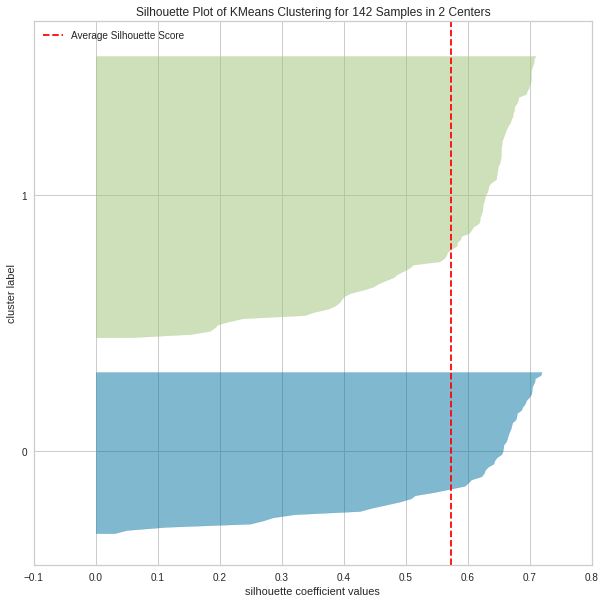

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

visualizer = SilhouetteVisualizer(kmeans, ax=ax, colors='yellowbrick')
visualizer.fit(df_life_expec_normalize)
visualizer.show();

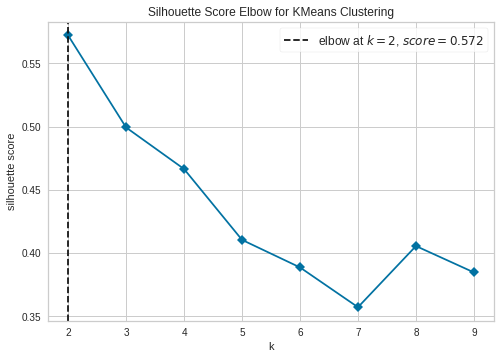

In [12]:
# Obtendo função parametrizada com Kmeans e indice de silhouette
visualizer = KElbowVisualizer(kmeans, k=(2,10), metric='silhouette', timings=False)

# Passando o valor da matriz normalizada
visualizer.fit(df_life_expec_normalize)        
visualizer.show()

### Acima é visualizado o número ótimo de clusters para k=2 e o score acima do 0.5 para o uso do Kmeans, neste caso a pré-visualização do dataset indica que os conjuntos dos clusters são convexos, terminando o uso do índice silhouette como meio de validação.

#### Através do gráfico de silhouette é visto que o cluster zero apresenta o maior número de países, como também possui o maior número acima da média, o que indica um problema de cardinalidade e coesão moderada. 

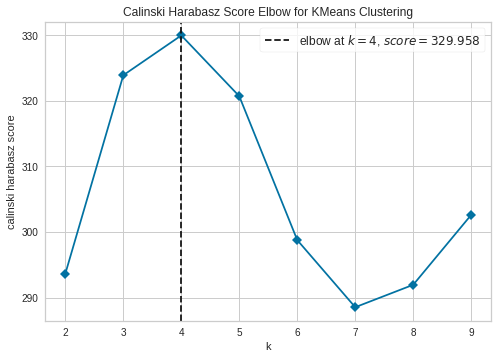

In [13]:
# Obtendo função parametrizada com Kmeans e indice de calinski_harabasz
visualizer = KElbowVisualizer(kmeans,k=(2,10), metric='calinski_harabasz', timings=False)

# Passando o valor da matriz normalizada
visualizer.fit(df_life_expec_normalize)        
visualizer.show()

#### A função silhouette_samples cria um array de valor para cada sample (valor da matriz) de forma que seja visualizado o coeficiente de silhouette. Podemos ver abaixo que 04 países possuem valor negativo, o que dizemos que talvez esses países estejam numa região de confusão e distantes do seu centroid. 

In [14]:
df_normalize_clusterized_2 = df_normalize_clusterized.copy()
df_normalize_clusterized_2["silhouette_score"] = silhouette_samples(StandardScaler().fit_transform(df_life_expec),kmeans.labels_,metric="euclidean")
df_normalize_clusterized_2[df_normalize_clusterized_2["db_scan"] >= 0].sort_values(by="silhouette_score").head(6)

,Life Expectancy (years) - Men,Life Expectancy (years) - Women,Happiness Score,kmeans,db_scan,silhouette_score
Country,,,,,,
Nepal,-0.242663,-0.247562,-0.898255,0,0,-0.249028
Indonesia,-0.287221,-0.455667,-0.432619,0,0,-0.243799
Mali,-1.742779,-1.704300,-1.171770,0,0,-0.198372
Mozambique,-0.821915,-0.903895,-1.199216,0,0,-0.194596
Botswana,-1.460579,-1.160024,-1.017504,0,0,-0.187775
"Congo, Rep.",-1.000147,-0.871878,-0.776168,0,0,-0.180803


> Escolha mais duas medidas de validação para comparar com o índice de silhueta e analise os resultados encontrados. Observe, para a escolha, medidas adequadas aos algoritmos.

### Aplicando a índice de Calinski Haravasz (possui a mesma função objetiva que silhouette) é visto o mesmo número ótimo de cluster, como também, valor positivo. O CH é, conhecido também como Variance ratio criterion, é uma medida simliar de avaliação de coesão e separação.

In [15]:
df_normalize_clusterized.drop("db_scan",axis=1).groupby("kmeans").describe()

Life Expectancy (years) - Men                                          \
                               count      mean       std       min       25%   
kmeans                                                                         
0                               52.0 -1.098974  0.599425 -2.871579 -1.568260   
1                               90.0  0.634963  0.514798 -0.168400  0.277179   

                                     Life Expectancy (years) - Women  \
             50%       75%       max                           count   
kmeans                                                                 
0      -1.059558 -0.699381  0.009832                            52.0   
1       0.447985  1.016098  1.747590                            90.0   

                  ...                     Happiness Score                      \
            mean  ...       75%       max           count      mean       std   
kmeans            ...                                                           
0      -1.101841  ... -0.667775 -0.023448            52.0 -1.034193  0.472118   
1       0.636619  ...  1.001071  1.977565            90.0  0.597534  0.685985   

                                                          
             min       25%       50%       75%       max  
kmeans                                                    
0      -2.121025 -1.251269 -0.982960 -0.645326 -0.320942  
1      -0.837685  0.119852  0.558279  1.039058  2.060241  

[2 rows x 24 columns]

In [16]:
df_life_expec_normalize_by_Standard = StandardScaler().fit_transform(df_life_expec_normalize)

kmeans_score = DBCV(df_life_expec_normalize_by_Standard, df_kmeans.labels_, dist_function=euclidean)
dbscan_score = DBCV(df_life_expec_normalize_by_Standard, df_db_scan.labels_, dist_function=euclidean)
print(kmeans_score, dbscan_score)

/usr/local/lib/python3.8/dist-packages/DBCV/DBCV.py:58: RuntimeWarning: invalid value encountered in double_scalars
  core_dist = (numerator / (n_neighbors - 1)) ** (-1/n_features)
/usr/local/lib/python3.8/dist-packages/DBCV/DBCV.py:217: RuntimeWarning: invalid value encountered in double_scalars
  cluster_validity = numerator / denominator


nan -0.5904625053100185


#### Com o resultado negativo demonstrado através do índice DBCV, constamos que a aplicação de qualquer validação baseada em desidade para este dataset possui um resultado negativo por ser tratar de um regreção linear e de clusters convexos. 

> Compare os dois resultados, aponte as semelhanças e diferenças e interprete.

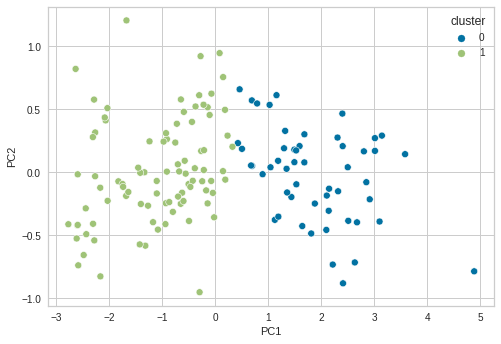

In [20]:
# Silhouette
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_life_expec_normalize)
plot_cluster_points(df_life_expec_normalize,kmeans)

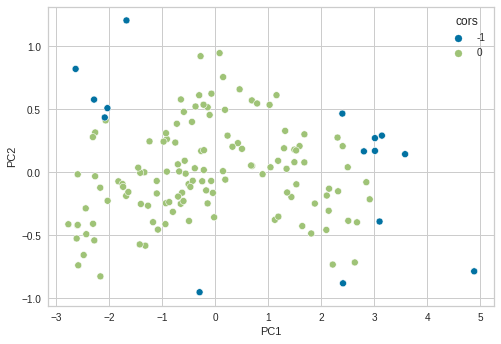

In [18]:
# DbScan
plot_dbScan_points(df_life_expec_normalize,df_db_scan)

#### Analisando o gráfico, resultado das distintas aplicações de clusterização, conseguimos notar que não há semelhanças no modelo. O que indica que, enquanto o clusters baseado em densidade (DBScan) aponta um único agrupamento e com ruídos (a variância do dado não valida a distinção e quantidade de cors), ocasionando um único cluster.

> Realizando a análise, responda: A silhueta é um o índice indicado para escolher o número de clusters para o algoritmo de DBScan

### Não, não é indicado por qualquer tipo de dataset, devendo realizar análise exploratório das variáveis e obtendo através de validações o número ótimo de clusrer.

### Medidas de similaridade

> Um determinado problema, apresenta 10 séries temporais distintas. Gostaríamos de agrupá-las em 3 grupos, de acordo com um critério de similaridade, baseado no valor máximo de correlação cruzada entre elas. Descreva em tópicos todos os passos necessários.

> Para o problema da questão anterior, indique qual algoritmo de clusterização você usaria. Justifique.

> Sugira outra estratégia para medir a similaridade entre séries temporais. Descreva em tópicos os passos necessários.

- Obtem a matriz de dados a ser analisado
- Analise temporal de dados sob o aspecto de encontro de similaridade e transformação
  - Vericar através do gráfico de histograma a distribuição de valores e frequência da série (pode ser usado o pairplot da seaborn para análise)
  - Obtido o gráfico verifica o tipo da distribuição para uma boa clusterização através da correlação/similaridade
    - Em casos de distribuição onde há uma simetria no histograma, o cálculo de similaridade e obtenção de valor será mais coeso/positivo na correlação de Pirson (significa dizer que a linearidade e uniformidade dos pontos na relação obtêm-se maior índice de correlação entre conjuntos)
    - Em casos de distribuição não normal, quando o histograma apresenta um gráfico não linear (distorcido, bimodal, porwer-low), a relação do conjunto será zero ou negativo sob a correlação de Pirson. Neste caso será necessário normalizar/transformar a série de dados ou obter um valor de similaridade linear onde consiga observar adequadamente a relação entre conjuntos.
      - Transformação do valor da série ((valor da séria - média) / distorção)
      - Coleta apenas os dados do conjunto por quartis (onde mais se apresenta similaridade)
      - Cálculo dos dados para reapresentação do valor mais linear (subtração temporal entre valores, uniformidade do conjunto)
  - De acordo com histograma aplica-se a transformação dos valores entre as 10 séries na tentativa de obter a correlação mais positiva possível do conjunto.
  - Agrupamento dos dados através da média/correlação cruzada/representação única por valor para cada conjunto das 10 séries (através de cada conjunto das 10 séries espera-se um valor único que represente bem a série temporal dos dados)
    - Obtém-se a média da série de cada conjunto (são 10 médias para as 10 séries)
      - Subtração das Máximas e mínimas dividas pela amostra
      - Média dos intervalos
      - Média dos desvios
      - Média movel
      - Média das correções dos valores das séries pelo próximo (corr de 1 com 2, 2 com 3, 3 com 4... dividido por N)
    - Obtem-se o valor normalizado dos conjuntos através da aplicação do cálculo de correlação cruzada
      - Multiplica-se o valor de cada conjunto da série subtraído pela média do conjunto e dividido pelo desvio padrão
      - Utiliza a função rolling para calcular Pirson na janela de tempo
  - Obtido os dados transformados de cada séria e representados, realiza a clusterização do novo conjunto.
    - Da primeira etapa do processo obteria a especificidade das séries, se os conjuntos tratam-se de medidas de distâncias entre valores (tempos de fenômenos, coeficientes entre pontos) seria usado algoritmos baseados em densidade
      - DB Scan
    - Da primeira etapa do processo obteria a especificidade das séries, se os conjuntos tratam-se de categorização, classificação e agrupamento
      - Kmeans
      - Hierárquico
  - De acordo com a especificidade da será clusterizado o conjunto de valores com DB Scan


> Indique um caso de uso para essa solução projetada.

##### Em casos de conjuntos de dados onde há necessidade de clusterização de melhor valor de preço entre vôos com escalas, onde escalas próximas para o destino é mais barato do que vôo direto. 